# Project 3: Recommendation Systems

## Group Members
- Shaira Alam

- Vani Agrawal 

- Dhakshina Ilango

# Imports 

In [2]:
! pip install surprise

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-win_amd64.whl size=1132995 sha256=9221b598d9436f66247032ad9acaa833a1612df109e10dfd7db63524b63255f5
  Stored in directory: c:\users\dhakshina\appdata\local\pip\cache\wheels\a5\ca\a8\4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, KNNBasic, accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from sklearn.metrics import roc_curve, auc
import os
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import ndcg_score
import lightgbm as lgb

In [31]:
df_ratings = pd.read_csv('./Synthetic_Movie_Lens/ratings.csv', index_col=None)
df_ratings.drop(columns=['Unnamed: 0'], inplace=True)
df_ratings.head()

,userId,movieId,rating,timestamp
0,496,112852,3.0,1415520462
1,391,1947,4.0,1030945141
2,387,1562,1.5,1095041022
3,474,2716,4.5,1053020930
4,483,88125,4.5,1311337237


Creation of Matrix R

In [32]:
R = df_ratings.pivot_table(index='userId', columns='movieId', values='rating')
R

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
R.fillna(0.0,inplace=True)
R

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Question 1

Explore the Dataset: In this question, we explore the structure of the data. 

A. Compute the sparsity of the movie rating dataset:  <br><br> ${Sparsity} = Total number of available ratings \div Total number of possible ratings$

In [10]:
total_available_ratings = R[R!=0].count().sum()
total_possible_ratings = R.shape[0] * R.shape[1]
sparsity = total_available_ratings/total_possible_ratings
print("Sparsity", sparsity)

Sparsity 0.016999683055613623


B. Plot a histogram showing the frequency of the rating values: Bin the raw rating values into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the number of entries in the ratings matrix R that fall within each bin and use this count as the height of the vertical axis for that particular bin. <br><br>Comment on the shape of the histogram.
It is a left Skewed Histogram. 

It is a left Skewed Histogram. 

In [11]:
ratings_array = R.values.flatten()
ratings_array

array([4., 0., 4., ..., 0., 0., 0.])

In [12]:
# Remove 0.0 values from the ratings_array
ratings_array = ratings_array[ratings_array != 0.0]

In [13]:
# Bins of width 0.5
bins = np.arange(0,5.5,0.5)

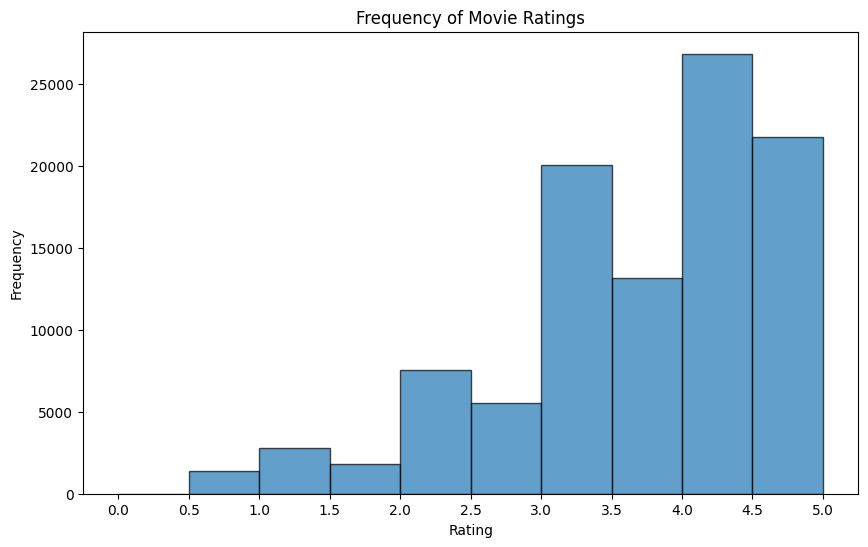

In [14]:
# Plot the histogram 
plt.figure(figsize=(10,6))
plt.hist(ratings_array, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Frequency of Movie Ratings')
plt.xticks(np.arange(0,5.5,0.5))
plt.show()

C. Plot the distribution of the number of ratings received among movies: The X-axis should be the movie index ordered by decreasing frequency and the Y -axis should be the number of ratings the movie has received; ties can broken in any way. A monotonically decreasing trend is expected.

In [15]:
ratings_per_movie = R.astype(bool).sum(axis=0)

In [16]:
# Total no of ratings per movie 
ratings_per_movie

movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Length: 9724, dtype: int64

In [17]:
# Sort in Decreasing Order 
sorted_movies = ratings_per_movie.sort_values(ascending=False)
sorted_movies

movieId
356       329
318       317
296       307
593       279
2571      278
         ... 
4093        1
4089        1
58351       1
4083        1
193609      1
Length: 9724, dtype: int64

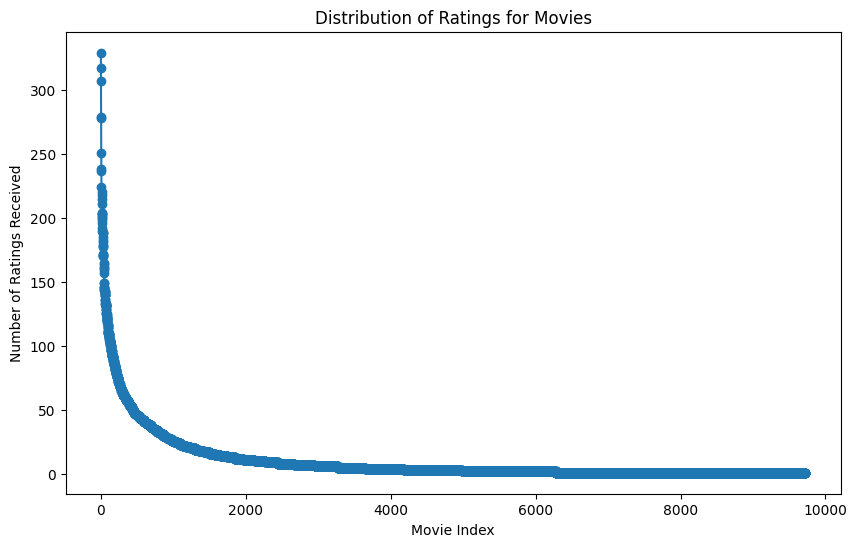

In [18]:
# Plot distribution of no of ratings for movies
plt.figure(figsize=(10, 6))
plt.plot(sorted_movies.values, marker='o', linestyle='-')
plt.xlabel('Movie Index')
plt.ylabel('Number of Ratings Received')
plt.title('Distribution of Ratings for Movies')
plt.show()

D. Plot the distribution of ratings among users: The X-axis should be the user index ordered by decreasing frequency and the Y -axis should be the number of movies the user has rated.The requirement of the plot is similar to that in Question C.

In [19]:
user_ratings_per_movie = R.astype(bool).sum(axis=1)
user_ratings_per_movie

userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Length: 610, dtype: int64

In [20]:
sorted_users = user_ratings_per_movie.sort_values(ascending=False)
sorted_users

userId
414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
442      20
569      20
320      20
576      20
53       20
Length: 610, dtype: int64

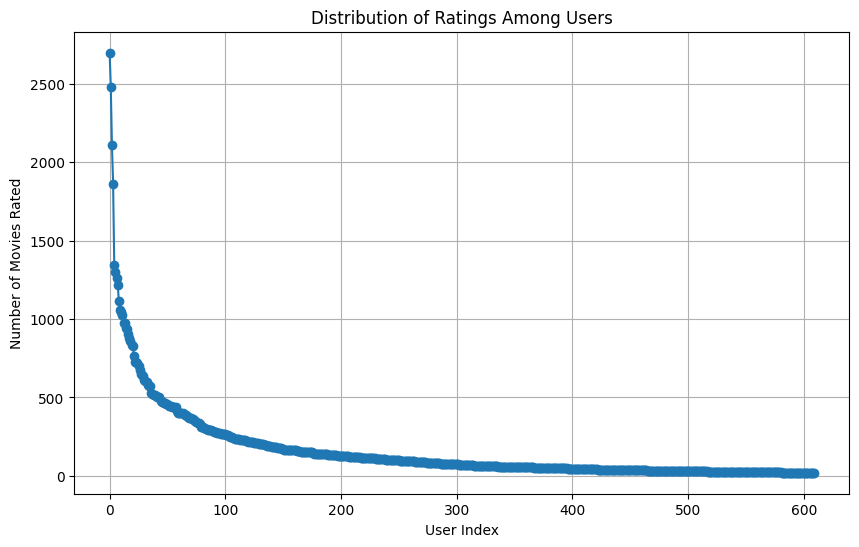

In [21]:
# Plot the distribution of the number of movies rated by users
plt.figure(figsize=(10, 6))
plt.plot(sorted_users.values, marker='o', linestyle='-')
plt.xlabel('User Index')
plt.ylabel('Number of Movies Rated')
plt.title('Distribution of Ratings Among Users')
plt.grid(True)
plt.show()

E. Discuss the salient features of the distributions from Questions C,D and their implications for the recommendation process.

For Question C it is a monotonically decreasing graph which suggests long tail distribution. That is a small fraction of movies have recieved high rating while the majority of movies have fewer ratings. Recommender systems should be able to provide reccommendaions for both popular as well as less popular movies. Understanding the distribution can help provide recommendations for movies with fewer ratings as well. 

For Question D the distribution provides insight about the engagement level of different users. This is similar to the long tail distrubution wherin a small portion of users might contribute to significant portion of ratings. Recommender systems can help personalize recommendations based on user engagement levels.

F. Compute the variance of the rating values received by each movie: Bin the variance values into intervals of width 0.5 and use the binned variance values as the horizontal axis. Count the number of movies with variance values in the binned intervals and use this count as the vertical axis. <br><br>Briefly comment on the shape of the resulting histogram.

A. It is right skewed. 

In [22]:
# Calculate variance per movie 
var_per_movie = R.var(axis=0, skipna=True)

In [23]:
var_per_movie

movieId
1         3.759444
2         1.882813
3         0.923073
4         0.070285
5         0.762920
            ...   
193581    0.026230
193583    0.020082
193585    0.020082
193587    0.020082
193609    0.026230
Length: 9724, dtype: float64

In [24]:
# Bin the variance values 
bins_one = np.arange(0, var_per_movie.max()+0.5, 0.5)

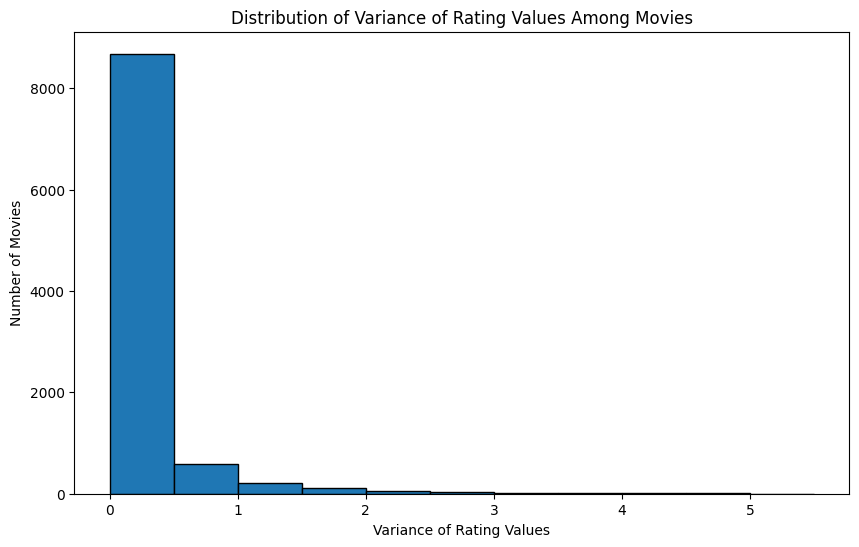

In [25]:
# Histogram
plt.figure(figsize=(10, 6))
plt.hist(var_per_movie, bins=bins_one, edgecolor='black')
plt.xlabel('Variance of Rating Values')
plt.ylabel('Number of Movies')
plt.title('Distribution of Variance of Rating Values Among Movies')
plt.show()

# QUESTION 2

Understanding the Pearson Correlation Coefficient:

A Write down the formula for μu in terms of Iu and ruk

The Pearson-correlation coefficient between users u and v denoted by Pearson(u,v) captures the similarity between the rating vectors of users u and v. First some notation:
- Iu : Set of item indices for which ratings have been specified by user u;
- Iv : Set of item indices for which ratings have been specified by user v;
- μu: Mean rating for user u computed using her specified ratings;
- ruk: Rating of user u for item k.


$$
\mu_u = \frac{1}{|I_u|} \sum_{k \in I_u} r_{uk}
$$

B In plain words, explain the meaning of Iu ∩ Iv. Can Iu ∩ Iv = ∅? (Hint: Rating matrix R is sparse)

${I_u}∩{I_v}$ is the common movies that has been rated by both user u and user v. ${I_u}∩{I_v} = ∅$ This can be true since the matrix R is sparse and there is a high probability of movies being present that are not rated by user u as well as user v

# QUESTION 3

Understanding the Prediction function: Can you explain the reason behind mean-centering the raw ratings (${r_{vj}} − {μ_v}$) in the prediction function? (Hint: Consider users who either rate all items highly or rate all items poorly and the impact of these users on the prediction function.)

$$\hat{r}_{uj} = \mu_u + \sum_{v \in P_u} \frac{{\text{Pearson}(u, v) \cdot (r_{vj} - \mu_v)}}{{\sum_{v \in P_u} |\text{Pearson}(u, v)|}}$$

This helps mitigate user bias as some users might highly rate movies while some users might rate movies poorly. Mean centering helps to normalize the values and center the ratings around zero.

# Question 4

Design a k-NN collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).

In [27]:
reader = Reader(rating_scale = (0.5,5))
data = Dataset.load_from_df(df_ratings[['userId','movieId','rating']], reader)

In [30]:
k_range = range(2,101,2)

In [29]:
avg_rmse_list = []
avg_mae_list = []

In [31]:
kf = KFold(n_splits=10)

# 10-fold cv
for k in k_range:
    
    # Initialize KNN model
    algo = KNNBasic(k=k, sim_options={'name': 'pearson'})
    
    # CV
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    
    # Avg RMSE and MAE
    avg_rmse = np.mean(results['test_rmse'])
    avg_mae = np.mean(results['test_mae'])
    
    avg_rmse_list.append(avg_rmse)
    avg_mae_list.append(avg_mae)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

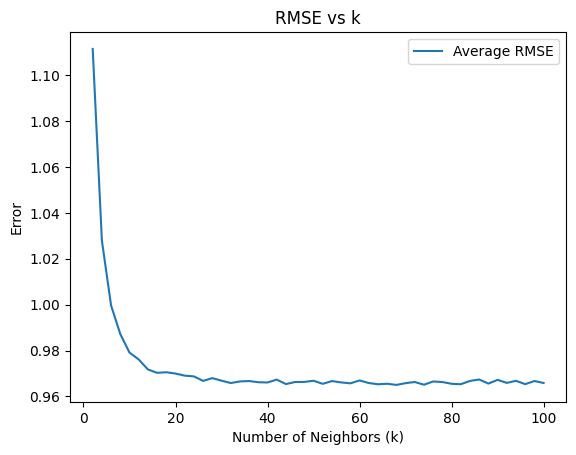

In [32]:
# Plot average RMSE and MAE against k
plt.plot(k_range, avg_rmse_list, label='Average RMSE')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error')
plt.title('RMSE vs k')
plt.legend()
plt.show()

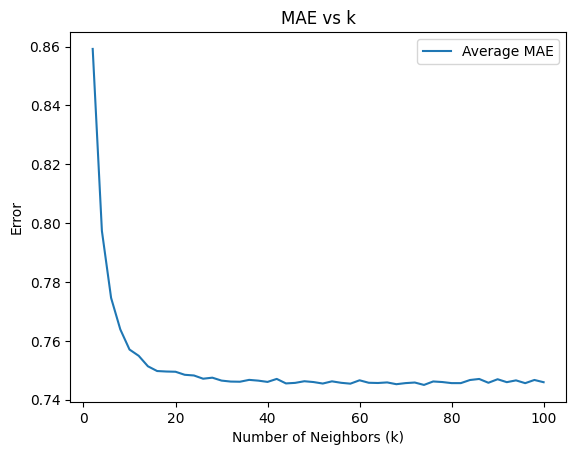

In [33]:
# Plot average RMSE and MAE against k
plt.plot(k_range, avg_mae_list, label='Average MAE')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error')
plt.title('MAE vs k')
plt.legend()
plt.show()

# Question 5 

Use the plot from question 4, to find a ’minimum k’. Note: The term ’minimum k’ in this context means that increasing k above the minimum value would not result in a significant decrease in average RMSE or average MAE. If you get the plot correct, then ’minimum k’ would correspond to the k value for which average RMSE and average MAE converges to a steady-state value. Please report the steady state values of average RMSE and average MAE.

The minimum value for which increase in k would not result in significant decrease in average RMSE or average MAE is k = 20. The steady state value of average RMSE is 0.9651938935314709 and the steady state value of average MAE is 0.7453313476198506.

# Question 6


A k-NN collaborative filter on the ratings of the movies (i.e Popular, Unpopular or High-Variance) and evaluate each of the three models performance using 10-fold cross validation:

- Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.


In [33]:
# Popular Movie Trimming 
def popular_movie_trimming(data, threshold=2):
    movie_ratings_count = data.groupby('movieId').size()
    popular_movies = movie_ratings_count[movie_ratings_count > threshold].index.tolist()
    trimmed_data = data[data['movieId'].isin(popular_movies)]
    return trimmed_data

# Unpopular Movie Trimming 
def unpopular_movie_trimming(data, threshold=2):
    movie_ratings_count = data.groupby('movieId').size()
    unpopular_movies = movie_ratings_count[movie_ratings_count <= threshold].index.tolist()
    trimmed_data = data[data['movieId'].isin(unpopular_movies)]
    return trimmed_data

# High Variance Movie Trimming 
# Movies that have variance of at least 2 and have received at least 5 ratings in the entire dataset.
def high_variance_movie_trimming(data, variance_threshold=2, ratings_threshold=5):
    movie_variances = data.groupby('movieId')['rating'].var()
    high_variance_movies = movie_variances[(movie_variances >= variance_threshold) & 
                                            (data['movieId'].value_counts() >= ratings_threshold)].index.tolist()
    trimmed_data = data[data['movieId'].isin(high_variance_movies)]
    return trimmed_data

In [34]:
popular_trimmed_data = popular_movie_trimming(df_ratings)
unpopular_trimmed_data = unpopular_movie_trimming(df_ratings)
high_variance_trimmed_data = high_variance_movie_trimming(df_ratings)

In [22]:
# Loading the trimmed datasets
reader = Reader(rating_scale=(0,5))
popular_dataset = Dataset.load_from_df(popular_trimmed_data[['userId', 'movieId', 'rating']], reader)
unpopular_dataset = Dataset.load_from_df(unpopular_trimmed_data[['userId', 'movieId', 'rating']], reader)
high_variance_dataset = Dataset.load_from_df(high_variance_trimmed_data[['userId', 'movieId', 'rating']], reader)

In [38]:
# Range of k values 
k_values = np.arange(0,101,2)

In [39]:
def compute_avg_rmse(dataset):
    kf = KFold(n_splits=10)
    avg_rmse_values = []
    for k in k_values:
        rmse_values = []
        algo = KNNBasic(k=k, sim_options={'name': 'pearson', 'user_based': True})
        for trainset, testset in kf.split(dataset):
            algo.fit(trainset)
            predictions = algo.test(testset)
            rmse_values.append(accuracy.rmse(predictions, verbose=False))
        avg_rmse = np.mean(rmse_values)
        avg_rmse_values.append(avg_rmse)
    min_avg_rmse = min(avg_rmse_values)
    return predictions, avg_rmse_values, min_avg_rmse

In [40]:
# Compute average RMSE values for each trimmed subset
alldata_predictions, alldata_avg_rmse, alldata_min_avg_rmse = compute_avg_rmse(data)
popular_predictions, popular_avg_rmse, popular_min_avg_rmse = compute_avg_rmse(popular_dataset)
unpopular_predictions, unpopular_avg_rmse, unpopular_min_avg_rmse = compute_avg_rmse(unpopular_dataset)
high_variance_predictions, high_variance_avg_rmse, high_variance_min_avg_rmse = compute_avg_rmse(high_variance_dataset)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

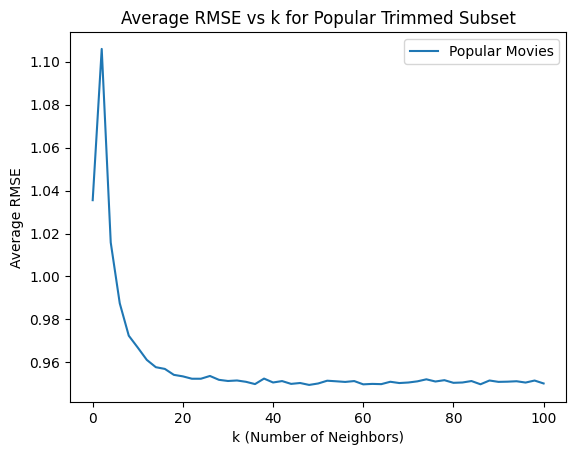

In [41]:
# Plots for RMSE against k for each trimmed subset
plt.plot(k_values, popular_avg_rmse, label='Popular Movies')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Average RMSE')
plt.title('Average RMSE vs k for Popular Trimmed Subset')
plt.legend()
plt.show()

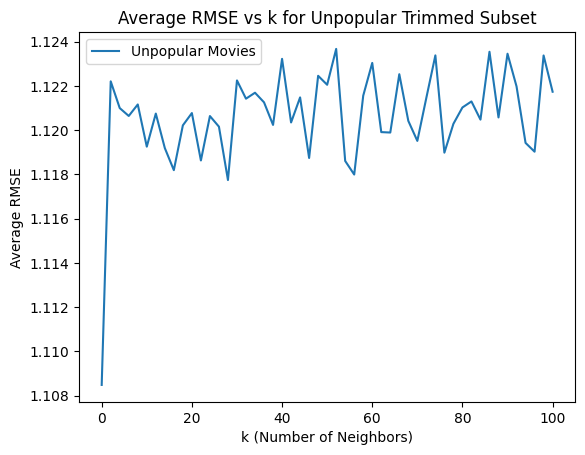

In [42]:
# Average RMSE against k for each trimmed subset
plt.plot(k_values, unpopular_avg_rmse, label='Unpopular Movies')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Average RMSE')
plt.title('Average RMSE vs k for Unpopular Trimmed Subset')
plt.legend()
plt.show()

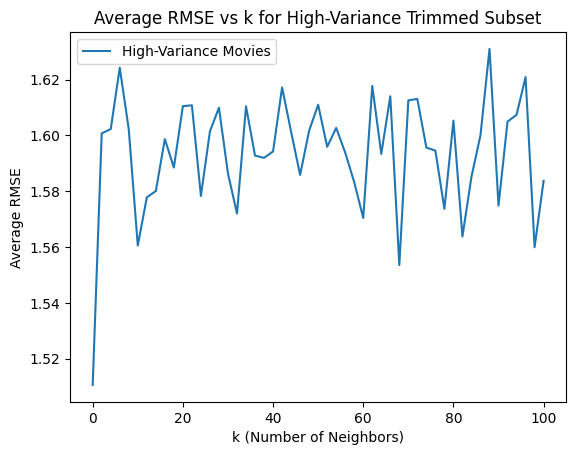

In [43]:
# Average RMSE against k for each trimmed subset
plt.plot(k_values, high_variance_avg_rmse, label='High-Variance Movies')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Average RMSE')
plt.title('Average RMSE vs k for High-Variance Trimmed Subset')
plt.legend()
plt.show()

In [44]:
# Report minimum average RMSE for each trimmed subset
print('Minimum Average RMSE for Popular Movies:', popular_min_avg_rmse)
print('Minimum Average RMSE for Unpopular Movies:', unpopular_min_avg_rmse)
print('Minimum Average RMSE for High-Variance Movies:', high_variance_min_avg_rmse)

Minimum Average RMSE for Popular Movies: 0.9495310161748665
Minimum Average RMSE for Unpopular Movies: 1.10848464155189
Minimum Average RMSE for High-Variance Movies: 1.5105485581079807


- Plot the ROC curves for the k-NN collaborative filters for threshold values [2.5, 3, 3.5, 4]. These thresholds are applied only on the ground truth labels in held-out validation set. For each of the plots, also report the area under the curve (AUC) value. You should have 4 × 4 plots in this section (4 trimming options – including no trimming times 4 thresholds) - all thresholds can be condensed into one plot per trimming option yielding only 4 plots.

In [45]:
def compute_roc_auc(predictions, threshold):
    true_labels = []
    predicted_labels = []
    for pred in predictions:
        true_labels.append(int(pred.r_ui >= threshold))
        predicted_labels.append(pred.est)
    fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

def plot_roc_curves(fprs, tprs, auc_scores, thresholds, subset_name):
    plt.figure(figsize=(10, 8))
    for i in range(len(thresholds)):
        plt.plot(fprs[i], tprs[i], label=f'Threshold={thresholds[i]}, AUC={auc_scores[i]:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {subset_name} Subset')
    plt.legend()
    plt.show()

In [46]:
# Threshold values
threshold_values = [2.5, 3, 3.5, 4]

# ROC curves and AUC for each trimmed subset
alldata_roc_data = []
popular_roc_data = []
unpopular_roc_data = []
high_variance_roc_data = []

In [47]:
for threshold in threshold_values:
    
    # ROC for all data
    alldata_fpr, alldata_tpr, alldata_auc = compute_roc_auc(alldata_predictions, threshold)
    alldata_roc_data.append((alldata_fpr, alldata_tpr, alldata_auc))
    
    # ROC for popular subset
    popular_fpr, popular_tpr, popular_auc = compute_roc_auc(popular_predictions, threshold)
    popular_roc_data.append((popular_fpr, popular_tpr, popular_auc))

    # ROC for unpopular subset
    unpopular_fpr, unpopular_tpr, unpopular_auc = compute_roc_auc(unpopular_predictions, threshold)
    unpopular_roc_data.append((unpopular_fpr, unpopular_tpr, unpopular_auc))

    # ROC for high variance subset
    high_variance_fpr, high_variance_tpr, high_variance_auc = compute_roc_auc(high_variance_predictions, threshold)
    high_variance_roc_data.append((high_variance_fpr, high_variance_tpr, high_variance_auc))

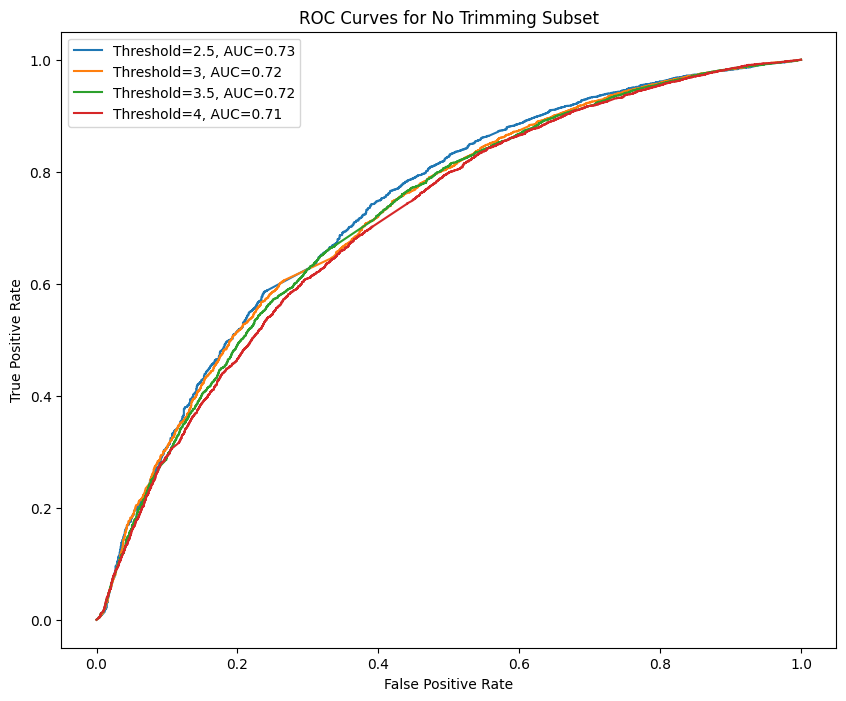

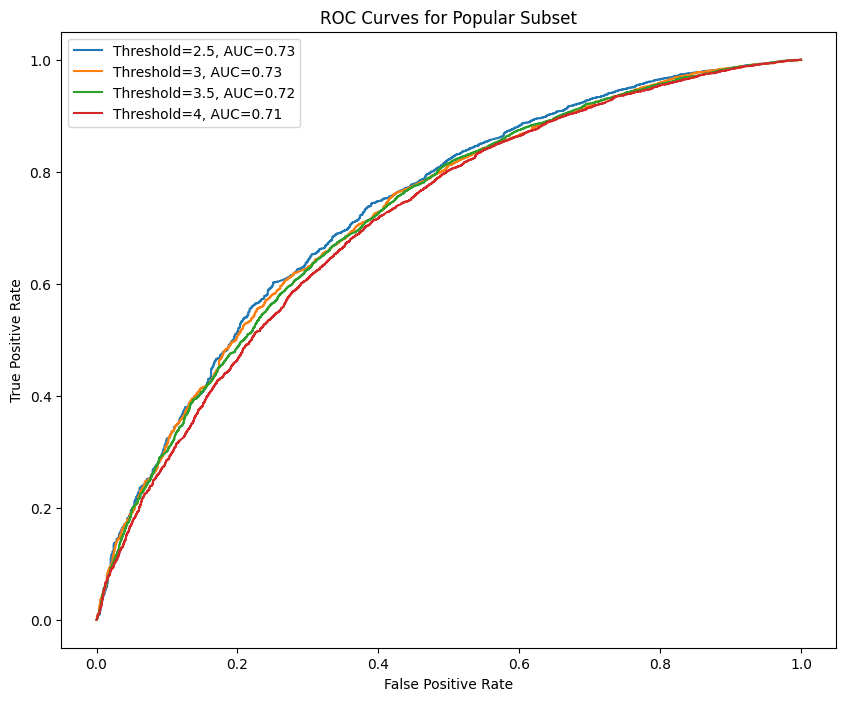

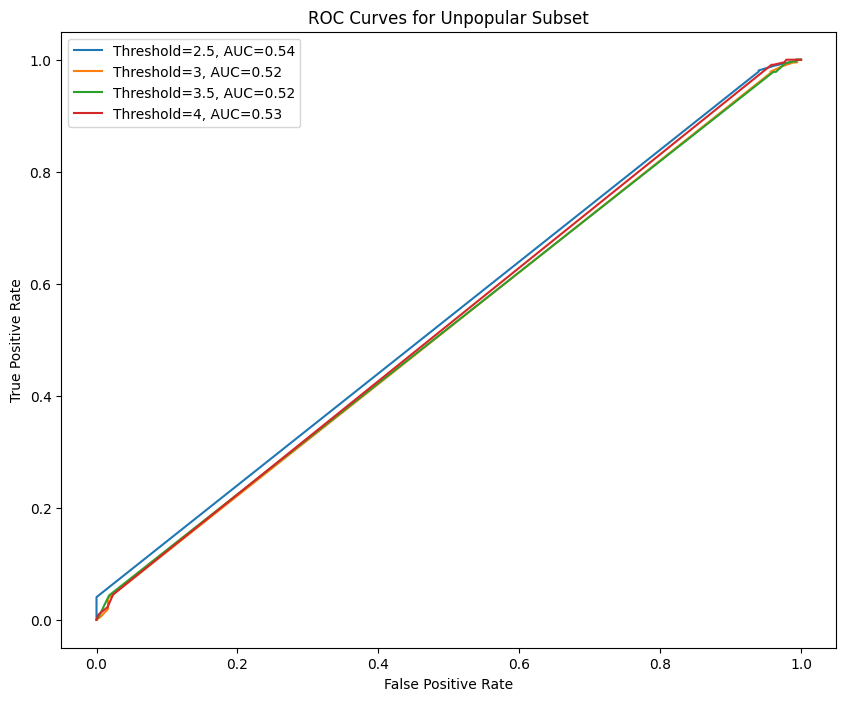

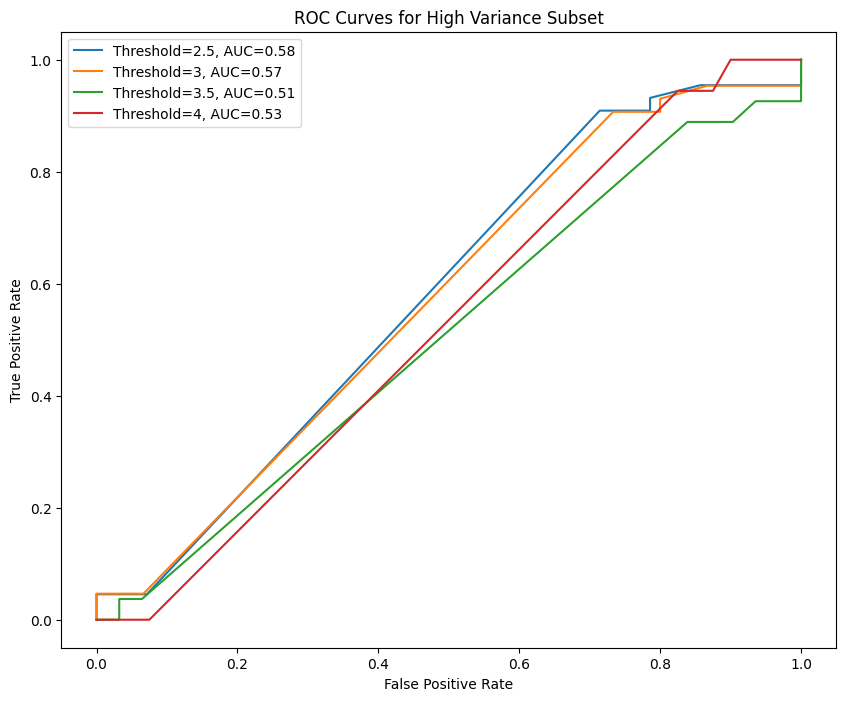

In [48]:
# ROC curves for each subset
plot_roc_curves(*zip(*alldata_roc_data), threshold_values, subset_name='No Trimming')
plot_roc_curves(*zip(*popular_roc_data), threshold_values, subset_name='Popular')
plot_roc_curves(*zip(*unpopular_roc_data), threshold_values, subset_name='Unpopular')
plot_roc_curves(*zip(*high_variance_roc_data), threshold_values, subset_name='High Variance')

# Question 7.1
Understanding the NMF cost function: Is the optimization problem given by equation 5 convex? Consider the optimization problem given by equation 5. 

Convex means that the function approaches all local minima to the global minima. In this equation, we want UV to approach less error between that and of matrix R. 

With that being said, there are multiple reasons why that equation is not convex equation: 
1. Squaring introduces non-linearity into the function. Because of this, the function can have multiple local minima, making it non-convex.
2. The products of the matrices U and V, introduces non-convexity. Convexity is remains when there is addition but not with multiplication. Therefore, the term UV^T contributes to the non-convexity of the objective function.
3. Matrix multiplication is inherently non-convex. With U and V being matrices and decision variables, the multiplication of U and V cause non-convexity. 

# Question 7.2
For U fixed, formulate it as a least-squares problem.

Remember equation 5: 

$$
\min_{U,V} \sum_{i=1}^{m} \sum_{j=1}^{n} W_{ij}(r_{ij} - (UV^T)_{ij})^2
$$

When U is fixed: 
$$
\min_{V} \sum_{i=1}^{m} \sum_{j=1}^{n} W_{ij}(r_{ij} - (UV^T)_{ij})^2
$$

r is the rank of the factorization, and it indexes the components of the factorization matrices U and V. Overall, this tries to reduce the error between the approximation and the original matrix R. 
$$
= \min_{V} \sum_{i=1}^{m} \sum_{j=1}^{n} W_{ij}(r_{ij} - \sum_{k=1}^{r} U_{ik}V_{jk})^2
$$


# Question 8
Designing the NMF Collaborative Filter

## A
Design a NMF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross-validation. 

Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. If NMF takes too long, you can increase the step size. Increasing it too much will result in poorer granularity in your results. 

Using Surprise

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle 

# surprise
from surprise import Dataset, Reader, NMF, KNNBasic, KNNWithMeans, accuracy, AlgoBase, SVD
from surprise.model_selection import KFold, cross_validate, train_test_split
from surprise.accuracy import rmse, mae

# sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, mean_squared_error

In [15]:
# Load the ratings dataset
reader = Reader(line_format='user item rating', sep=',', rating_scale=(1, 5), skip_lines=1)
ratings_dataset = df_ratings[['userId', 'movieId', 'rating']]
ratings_dataset = Dataset.load_from_df(ratings_dataset, reader=reader)

# Define range of latent factors (k values)
latent_factors_range = range(2, 51, 2)

# Initialize lists to store results
avg_rmse_scores = []
avg_mae_scores = []

for k in latent_factors_range:
    # Choose the NMF algorithm with the current number of latent factors
    nmf = NMF(n_factors=k)
    
    # Perform cross-validation
    results = cross_validate(nmf, ratings_dataset, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    
    # Calculate average RMSE and MAE for this k
    avg_rmse = np.mean(results['test_rmse'])
    avg_mae = np.mean(results['test_mae'])

    avg_rmse_scores.append(avg_rmse)
    avg_mae_scores.append(avg_mae)

Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Yaxis) against k (X-axis). For solving this question, use the default value for the regularization parameter.

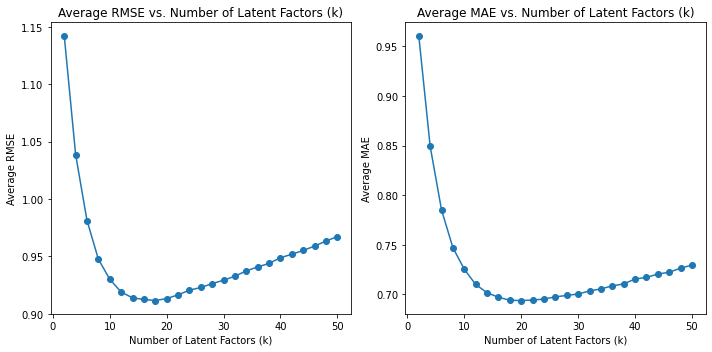

In [16]:
# Plot results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(latent_factors_range, avg_rmse_scores, marker='o')
plt.title('Average RMSE vs. Number of Latent Factors (k)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')

plt.subplot(1, 2, 2)
plt.plot(latent_factors_range, avg_mae_scores, marker='o')
plt.title('Average MAE vs. Number of Latent Factors (k)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average MAE')

plt.tight_layout()
plt.show()

## B
Use the plot from the previous part to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. 

In [17]:
# Index of minimum average score 
min_rmse_index = np.argmin(avg_rmse_scores)
min_mae_index = np.argmin(avg_mae_scores)

# Optimal latent factor given index of minimum average 
k_optimal_rmse = latent_factors_range[min_rmse_index]
k_optimal_mae = latent_factors_range[min_mae_index]

# Minimum average score 
min_avg_rmse = avg_rmse_scores[min_rmse_index]
min_avg_mae = avg_mae_scores[min_mae_index]

print("Optimal number of latent factors for minimum RMSE:", k_optimal_rmse)
print("Minimum average RMSE:", min_avg_rmse)

print("\nOptimal number of latent factors for minimum MAE:", k_optimal_mae)
print("Minimum average MAE:", min_avg_mae)


Optimal number of latent factors for minimum RMSE: 18
Minimum average RMSE: 0.9114661697684031

Optimal number of latent factors for minimum MAE: 20
Minimum average MAE: 0.6937827613240668


Is the optimal number of latent factors same as the number of movie genres?

In [18]:
import pandas as pd

# Load the dataset into a DataFrame
movies_df = pd.read_csv("./Synthetic_Movie_Lens/movies.csv")

# Split genres and count unique genres
all_genres = movies_df['genres'].str.split('|').explode().str.strip()
num_unique_genres = all_genres.nunique()

print("Number of unique genres:", num_unique_genres)

Number of unique genres: 20


The optimal number of latent factors is the same as the number of movie genres. 

## C
Performance on trimmed dataset subsets: For each of Popular, Unpopular and High-Variance subsets:

Design a NMF collaborative filter for each trimmed subset and evaluate its performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds.

In [19]:
import pandas as pd
import numpy as np

def compute_avg_rmse_nmf_cf(dataset, latent_factors_range): 
    reader = Reader(line_format='user item rating', sep=',', rating_scale=(1, 5), skip_lines=1)
    dataset = Dataset.load_from_df(dataset, reader=reader)
    
    # Initialize lists to store results
    avg_rmse_scores = []
    k_values = []

    kf = KFold(n_splits=10, random_state=42)

    for k in latent_factors_range:
        rmse_scores = []
        for train, test in kf.split(dataset):
            # Train NMF algorithm on the trainset
            nmf = NMF(n_factors=k)
            nmf.fit(train)

            pred = nmf.test(test)

            # get RMSE value on the prediction
            rsme_score = rmse(pred, verbose=False)

            # Append RMSE value to list 
            rmse_scores.append(rsme_score) 

        avg_rmse = np.mean(rmse_scores)
        avg_rmse_scores.append(avg_rmse)
        k_values.append(k)

    return avg_rmse_scores, k_values


In [38]:
ratings_df = pd.read_csv("./Synthetic_Movie_Lens/ratings.csv")

In [39]:
def popular_trimming(movie_ratings, threshold):
    # Trim dataset to contain movies with more than the threshold ratings
    popular_movies = movie_ratings[movie_ratings['count'] > threshold]['movieId']
    return ratings_df[ratings_df['movieId'].isin(popular_movies)]

def unpopular_trimming(movie_ratings, threshold):
    # Trim dataset to contain movies with less than or equal to the threshold ratings
    unpopular_movies = movie_ratings[movie_ratings['count'] <= threshold]['movieId']
    return ratings_df[ratings_df['movieId'].isin(unpopular_movies)]

def high_variance_trimming(movie_ratings, variance_threshold, count_threshold):
    # Trim dataset to contain movies with variance >= variance_threshold and at least count_threshold ratings
    high_variance_movies = movie_ratings[(movie_ratings['count'] >= count_threshold) &
                                        (movie_ratings['var'] >= variance_threshold)]['movieId']
    return ratings_df[ratings_df['movieId'].isin(high_variance_movies)]

In [40]:
# Define range of latent factors (k values)
latent_factors_range = range(2, 51, 2)

ratings = ratings_df.pivot(index='userId', columns='movieId', values='rating').fillna(0).values
ratings_count = ratings_df.groupby('movieId')['rating'].agg(['count', 'var']).reset_index()

# Load your trimmed dataset subsets into DataFrames
popular_subset = popular_trimming(ratings_count, 2).drop(columns=['Unnamed: 0', 'timestamp'])
unpopular_subset = unpopular_trimming(ratings_count, 2).drop(columns=['Unnamed: 0', 'timestamp'])
high_variance_subset = high_variance_trimming(ratings_count, 2, 5).drop(columns=['Unnamed: 0', 'timestamp'])

# Convert numpy array to dataframe
popular_subset = pd.DataFrame(popular_subset)
unpopular_subset = pd.DataFrame(unpopular_subset)
high_variance_subset = pd.DataFrame(high_variance_subset)

# Perform analysis for each subset type
subset_types = {
    'no_trim': ratings_df[['userId', 'movieId', 'rating']],
    'popular': popular_subset,
    'unpopular': unpopular_subset,
    'high_variance': high_variance_subset
}

No trim

In [41]:
no_trim_rmse_nmf_cf = compute_avg_rmse_nmf_cf(subset_types['no_trim'], latent_factors_range)

Popular

In [42]:
popular_rmse_nmf_cf = compute_avg_rmse_nmf_cf(subset_types['popular'], latent_factors_range)

Unpopular

In [43]:
unpopular_rmse_nmf_cf = compute_avg_rmse_nmf_cf(subset_types['unpopular'], latent_factors_range)

High Variance

In [44]:
high_variance_rmse_nmf_cf = compute_avg_rmse_nmf_cf(subset_types['high_variance'], latent_factors_range)

Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.

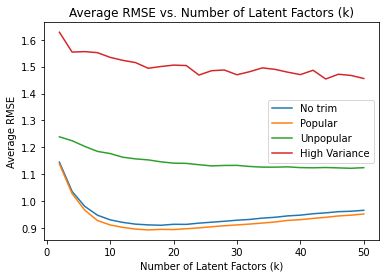

Minimum Average RMSE (No trim): 0.9103307334131756
Minimum Average RMSE (Popular): 0.8930550381280458
Minimum Average RMSE (Unpopular): 1.1222326527485482
Minimum Average RMSE (High Variance): 1.4541166966275363


In [45]:
import matplotlib.pyplot as plt

# Plot results
plt.plot(latent_factors_range, no_trim_rmse_nmf_cf[0], label='No trim')
plt.plot(latent_factors_range, popular_rmse_nmf_cf[0], label='Popular')
plt.plot(latent_factors_range, unpopular_rmse_nmf_cf[0], label='Unpopular')
plt.plot(latent_factors_range, high_variance_rmse_nmf_cf[0], label='High Variance')
plt.title('Average RMSE vs. Number of Latent Factors (k)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.legend()
plt.show()

# Report minimum average RMSE
min_avg_no_trim_rmse_nmf_cf = min(no_trim_rmse_nmf_cf[0])
min_avg_popular_rmse_nmf_cf = min(popular_rmse_nmf_cf[0])
min_avg_unpopular_rmse_nmf_cf = min(unpopular_rmse_nmf_cf[0])
min_avg_high_variance_rmse_nmf_cf = min(high_variance_rmse_nmf_cf[0])

print("Minimum Average RMSE (No trim):", min_avg_no_trim_rmse_nmf_cf)
print("Minimum Average RMSE (Popular):", min_avg_popular_rmse_nmf_cf)
print("Minimum Average RMSE (Unpopular):", min_avg_unpopular_rmse_nmf_cf)
print("Minimum Average RMSE (High Variance):", min_avg_high_variance_rmse_nmf_cf)

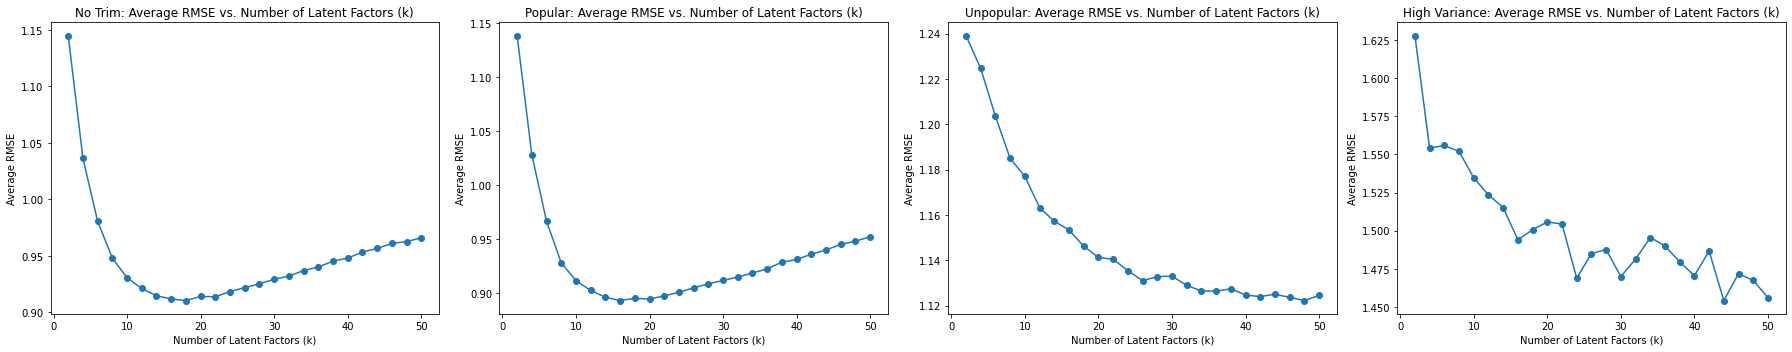

In [46]:
# Plot results
plt.figure(figsize=(25, 5))

plt.subplot(1, 4, 1)
plt.plot(latent_factors_range, no_trim_rmse_nmf_cf[0], label='No trim', marker='o')
plt.title('No Trim: Average RMSE vs. Number of Latent Factors (k)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')

plt.subplot(1, 4, 2)
plt.plot(latent_factors_range, popular_rmse_nmf_cf[0], label='Popular', marker='o')
plt.title('Popular: Average RMSE vs. Number of Latent Factors (k)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')

plt.subplot(1, 4, 3)
plt.plot(latent_factors_range, unpopular_rmse_nmf_cf[0], label='Unpopular', marker='o')
plt.title('Unpopular: Average RMSE vs. Number of Latent Factors (k)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')

plt.subplot(1, 4, 4)
plt.plot(latent_factors_range, high_variance_rmse_nmf_cf[0], label='High Variance', marker='o')
plt.title('High Variance: Average RMSE vs. Number of Latent Factors (k)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')

plt.tight_layout()
plt.show()

In [47]:
# No trim
min_rmse_index_no_trim = np.argmin(no_trim_rmse_nmf_cf[0])
k_optimal_rmse_no_trim = latent_factors_range[min_rmse_index_no_trim]
print("Optimal number of latent factors for No Trim:", k_optimal_rmse_no_trim)

# Popular
min_rmse_index_popular = np.argmin(popular_rmse_nmf_cf[0])
k_optimal_rmse_popular = latent_factors_range[min_rmse_index_popular]
print("Optimal number of latent factors for Popular:", k_optimal_rmse_popular)

# Unpopular
min_rmse_index_unpopular = np.argmin(unpopular_rmse_nmf_cf[0])
k_optimal_rmse_unpopular = latent_factors_range[min_rmse_index_unpopular]
print("Optimal number of latent factors for Unopular:", k_optimal_rmse_unpopular)

# Index of minimum average score 
min_rmse_index_high_var = np.argmin(high_variance_rmse_nmf_cf[0])
k_optimal_rmse_high_var = latent_factors_range[min_rmse_index_high_var]
print("Optimal number of latent factors for High Variance:", k_optimal_rmse_high_var)

Optimal number of latent factors for No Trim: 18
Optimal number of latent factors for Popular: 16
Optimal number of latent factors for Unopular: 48
Optimal number of latent factors for High Variance: 44


## D
Plot the ROC curves for the NMF-based collaborative filter and also report the area under the curve (AUC) value as done in Question 6.

In [48]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc

def compute_roc_auc(true_ratings, predicted_ratings):
    fpr, tpr, _ = roc_curve(true_ratings, predicted_ratings)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

def compute_avg_roc_nmf_cf(dataset, latent_factors_range, thresholds): 
    reader = Reader(line_format='user item rating', sep=',', rating_scale=(1, 5), skip_lines=1)
    dataset = Dataset.load_from_df(dataset, reader=reader)
    
    avg_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []

    kf = KFold(n_splits=10, random_state=42)

    for k in latent_factors_range:
        tpr_list = []
        for train, test in kf.split(dataset):
            # Train NMF algorithm on the trainset
            nmf = NMF(n_factors=k)
            nmf.fit(train)

            # Make predictions on the testset
            predictions = nmf.test(test)

            # Extract true ratings and predicted ratings
            true_ratings = np.array([pred.r_ui for pred in predictions])
            predicted_ratings = np.array([pred.est for pred in predictions])

            # per threshold 
            for threshold in thresholds: 
                true_labels = [1 if rating >= threshold else 0 for rating in true_ratings]

                # Compute ROC curve and AUC
                fpr, tpr, roc_auc = compute_roc_auc(true_labels, predicted_ratings)

                # Interpolate ROC curve to average FPR points
                interp_tpr = np.interp(avg_fpr, fpr, tpr)
                interp_tpr[0] = 0.0
                tpr_list.append(interp_tpr)

        # Compute average TPR across all folds
        mean_tpr = np.mean(tpr_list, axis=0)
        mean_tpr[-1] = 1.0
        tprs.append(mean_tpr)

        # Compute AUC for this k
        roc_auc = auc(avg_fpr, mean_tpr)
        aucs.append(roc_auc)

    return avg_fpr, tprs, aucs

In [49]:
def plot_roc_auc(avg_fpr, tprs, aucs, thresholds, latent_factors_range, optimal_k): 
    plt.figure(figsize=(10, 6))
    
    for i, threshold in enumerate(thresholds):
        plt.plot(avg_fpr, tprs[i], lw=1, label=f'Threshold={threshold} (AUC = {aucs[i]:.2f})')
            
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for NMF-based Collaborative Filter for k={optimal_k}')
    plt.legend(loc="lower right")
    plt.show()

In [50]:
# Define threshold values
thresholds = [2.5, 3, 3.5, 4]

No trim

In [51]:
avg_fpr_no_trim, tprs_no_trim, aucs_no_trim = compute_avg_roc_nmf_cf(subset_types['no_trim'], latent_factors_range, thresholds)

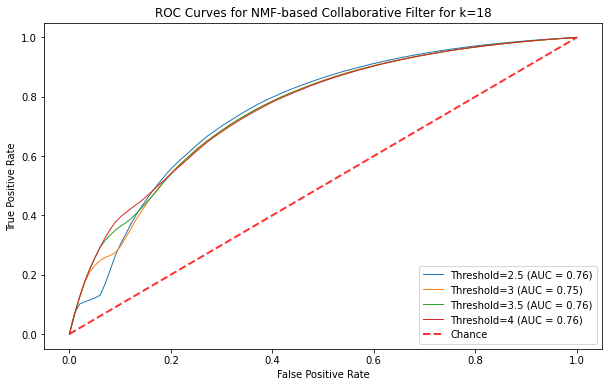

In [52]:
plot_roc_auc(avg_fpr_no_trim, tprs_no_trim, aucs_no_trim, thresholds, latent_factors_range, k_optimal_rmse_no_trim)

Popular

In [53]:
avg_fpr_popular, tprs_popular, aucs_popular = compute_avg_roc_nmf_cf(subset_types['popular'], latent_factors_range, thresholds)

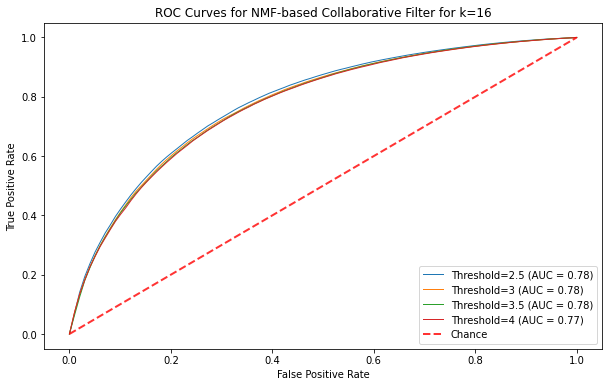

In [54]:
plot_roc_auc(avg_fpr_popular, tprs_popular, aucs_popular, thresholds, latent_factors_range, k_optimal_rmse_popular)

Unpopular

In [55]:
# Plot ROC curves for different trimming options and threshold values
avg_fpr_unpopular, tprs_unpopular, aucs_unpopular = compute_avg_roc_nmf_cf(subset_types['unpopular'], latent_factors_range, thresholds)

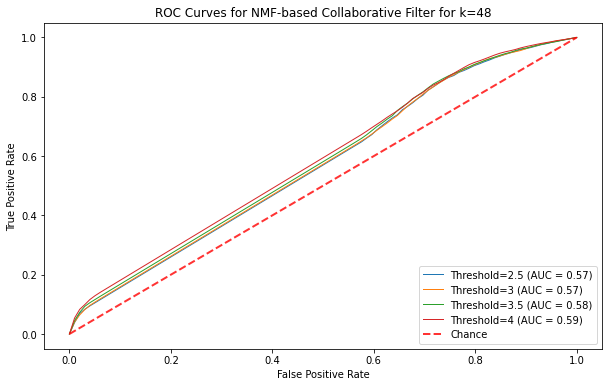

In [56]:
plot_roc_auc(avg_fpr_unpopular, tprs_unpopular, aucs_unpopular, thresholds, latent_factors_range, k_optimal_rmse_unpopular)

High Variance

In [57]:
avg_fpr_high_var, tprs_high_var, aucs_high_var = compute_avg_roc_nmf_cf(subset_types['high_variance'], latent_factors_range, thresholds)

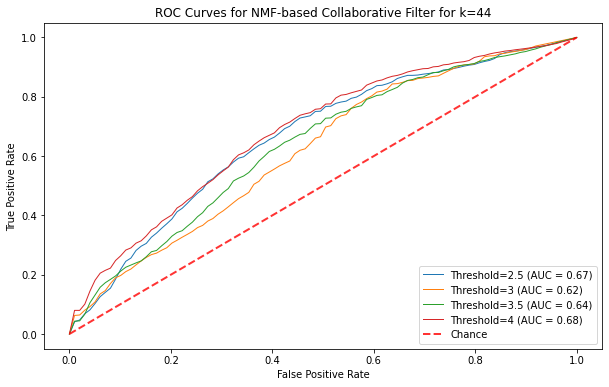

In [58]:
plot_roc_auc(avg_fpr_high_var, tprs_high_var, aucs_high_var, thresholds, latent_factors_range, k_optimal_rmse_high_var)

# Question 9

## A 
Interpreting the NMF model: Perform Non-negative matrix factorization on the ratings matrix R to obtain the factor matrices U and V , where U represents the user-latent factors interaction and V represents the movie-latent factors interaction (use k = 20). For each column of V , sort the movies in descending order and report the genres of the top 10 movies. 

In [59]:
reader = Reader(line_format='user item rating', sep=',', rating_scale=(1, 5), skip_lines=1)
ratings_dataset = ratings_df[['userId', 'movieId', 'rating']]
ratings_dataset = Dataset.load_from_df(ratings_dataset, reader=reader)

# Define the number of latent factors (k)
k = 20

train, test = train_test_split(ratings_dataset, test_size=0.2, random_state=42)

# Perform Non-negative Matrix Factorization (NMF)
nmf = NMF(n_factors=k, random_state=42)
nmf.fit(train)

# Get the user-latent factors interaction matrix (U)
U = nmf.pu

# Get the item-latent factors interaction matrix (V)
V = nmf.qi

# Get movie IDs and genres
movie_ids = movies_df['movieId']
genres = movies_df['genres']
# movie_id = ratings['movieId'].unique()

# For each latent factor
for i in range(k):
    # Get the indices of the top 10 movies for this latent factor
    top_movies_indices = V[i].argsort()[::-1][:10]
    
    print(f"Top 10 movies for Latent Factor {i+1}:")
    for idx in top_movies_indices:
        movie_id = movie_ids[idx]
        movie_genres = genres[idx]
        print(f"Movie ID: {movie_id}, Genres: {movie_genres}")
    print()


Top 10 movies for Latent Factor 1:
Movie ID: 15, Genres: Action|Adventure|Romance
Movie ID: 2, Genres: Adventure|Children|Fantasy
Movie ID: 11, Genres: Comedy|Drama|Romance
Movie ID: 18, Genres: Comedy
Movie ID: 12, Genres: Comedy|Horror
Movie ID: 9, Genres: Action
Movie ID: 13, Genres: Adventure|Animation|Children
Movie ID: 20, Genres: Action|Comedy|Crime|Drama|Thriller
Movie ID: 17, Genres: Drama|Romance
Movie ID: 16, Genres: Crime|Drama

Top 10 movies for Latent Factor 2:
Movie ID: 6, Genres: Action|Crime|Thriller
Movie ID: 14, Genres: Drama
Movie ID: 15, Genres: Action|Adventure|Romance
Movie ID: 7, Genres: Comedy|Romance
Movie ID: 17, Genres: Drama|Romance
Movie ID: 20, Genres: Action|Comedy|Crime|Drama|Thriller
Movie ID: 12, Genres: Comedy|Horror
Movie ID: 13, Genres: Adventure|Animation|Children
Movie ID: 16, Genres: Crime|Drama
Movie ID: 18, Genres: Comedy

Top 10 movies for Latent Factor 3:
Movie ID: 10, Genres: Action|Adventure|Thriller
Movie ID: 20, Genres: Action|Comedy|Cri

## B
Do the top 10 movies belong to a particular or a small collection of genre? 

In [60]:
from collections import Counter

# Initialize a Counter to store genre counts
genre_counts = Counter()

# For each latent factor
for i in range(k):
    # Get the indices of the top 10 movies for this latent factor
    top_movies_indices = V[i].argsort()[::-1][:10]
    
    # Extract genres of the top 10 movies
    top_movies_genres = genres[top_movies_indices].str.split('|')
    
    # Flatten the list of genres
    top_movies_genres_flat = [genre for sublist in top_movies_genres for genre in sublist]
    
    # Update the genre counts
    genre_counts.update(top_movies_genres_flat)

# Print the most common genres
print("Most common genres among top 10 movies for each latent factor:")
for genre, count in genre_counts.most_common():
    print(f"{genre}: {count} times")


Most common genres among top 10 movies for each latent factor:
Comedy: 98 times
Adventure: 67 times
Drama: 60 times
Romance: 59 times
Action: 47 times
Children: 45 times
Thriller: 28 times
Fantasy: 26 times
Crime: 25 times
Animation: 22 times
Horror: 11 times


## C
Is there a connection between the latent factors and the movie genres?

NMF aims to decompose the original ratings matrix into two matrices, one representing user-latent factor interactions and the other representing movie-latent factor interactions. These latent factors capture underlying patterns or features in the data. If the movies in the dataset are associated with specific genres, the latent factors obtained through NMF may also capture these genre-related patterns. In other words, certain latent factors may correspond to particular genres or combinations of genres. For example, latent factors may represent abstract features such as "action", "romance", "comedy", "drama", etc., which are common themes across movies. 

# Question 10
Designing the MF Collaborative Filter

## A
Design a MF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.

In [64]:
# Load the ratings dataset
reader = Reader(line_format='user item rating', sep=',', rating_scale=(1, 5), skip_lines=1)
ratings_dataset = ratings_df[['userId', 'movieId', 'rating']]
ratings_dataset = Dataset.load_from_df(ratings_dataset, reader=reader)

# Define range of latent factors (k values)
latent_factors_range = range(2, 51, 2)

# Initialize lists to store results
avg_rmse_scores_mf_cf = []
avg_mae_scores_mf_cf = []

for k in latent_factors_range:
    mf = SVD(n_factors=k)
    
    # Perform cross-validation
    results_mf_cf = cross_validate(mf, ratings_dataset, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    
    # Calculate average RMSE and MAE for this k
    avg_rmse_mf_cf = np.mean(results_mf_cf['test_rmse'])
    avg_mae_mf_cf = np.mean(results_mf_cf['test_mae'])

    avg_rmse_scores_mf_cf.append(avg_rmse_mf_cf)
    avg_mae_scores_mf_cf.append(avg_mae_mf_cf)

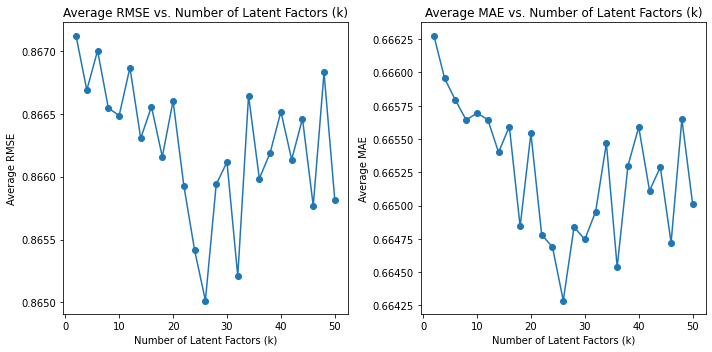

In [65]:
# Plot results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(latent_factors_range, avg_rmse_scores_mf_cf, marker='o')
plt.title('Average RMSE vs. Number of Latent Factors (k)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')

plt.subplot(1, 2, 2)
plt.plot(latent_factors_range, avg_mae_scores_mf_cf, marker='o')
plt.title('Average MAE vs. Number of Latent Factors (k)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average MAE')

plt.tight_layout()
plt.show()

## B
Use the plot from the previous part to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. 

In [66]:
# Find the index of the minimum average RMSE and MAE
min_rmse_index_mf_cf = np.argmin(avg_rmse_scores_mf_cf)
min_mae_index_mf_cf = np.argmin(avg_mae_scores_mf_cf)

# Optimal number of latent factors based on RMSE and MAE
optimal_k_rmse_mf_cf = latent_factors_range[min_rmse_index_mf_cf]
optimal_k_mae_mf_cf = latent_factors_range[min_mae_index_mf_cf]

# Minimum average RMSE and MAE
min_avg_rmse_mf_cf = avg_rmse_scores_mf_cf[min_rmse_index_mf_cf]
min_avg_mae_mf_cf = avg_mae_scores_mf_cf[min_mae_index_mf_cf]

print("Optimal number of latent factors for minimum RMSE:", optimal_k_rmse_mf_cf)
print("Minimum average RMSE:", min_avg_rmse_mf_cf)

print("\nOptimal number of latent factors for minimum MAE:", optimal_k_mae_mf_cf)
print("Minimum average MAE:", min_avg_mae_mf_cf)


Optimal number of latent factors for minimum RMSE: 26
Minimum average RMSE: 0.8650146293996975

Optimal number of latent factors for minimum MAE: 26
Minimum average MAE: 0.664286256639424


Is the optimal number of latent factors same as the number of movie genres?

In [67]:
import pandas as pd

# Load the dataset into a DataFrame
movies_df = pd.read_csv("Synthetic_Movie_Lens/movies.csv")  # Replace "movies.csv" with the actual path to your CSV file

# Split genres and count unique genres
all_genres = movies_df['genres'].str.split('|').explode().str.strip()
num_unique_genres = all_genres.nunique()

print("Number of unique genres:", num_unique_genres)

Number of unique genres: 20


The optimal number of latent factors is not the same. 

## C
Performance on dataset subsets: For each of Popular, Unpopular and High-Variance subsets

Design a MF collaborative filter for each trimmed subset and evaluate its performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds.

In [68]:
import pandas as pd
import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error
# from sklearn.decomposition import NMF

def compute_avg_rmse_mf_cf(dataset, latent_factors_range): 
    reader = Reader(line_format='user item rating', sep=',', rating_scale=(1, 5), skip_lines=1)
    dataset = Dataset.load_from_df(dataset, reader=reader)
    
    # Initialize lists to store results
    avg_rmse_scores = []
    k_values = []

    kf = KFold(n_splits=10, random_state=42)

    for k in latent_factors_range:
        rmse_scores = []
        for train, test in kf.split(dataset):
            # Train NMF algorithm on the trainset
            nmf = SVD(n_factors=k)
            nmf.fit(train)

            pred = nmf.test(test)

            # get RMSE value on the prediction
            rsme_score = rmse(pred, verbose=False)

            # Append RMSE value to list 
            rmse_scores.append(rsme_score) 

        avg_rmse = np.mean(rmse_scores)
        avg_rmse_scores.append(avg_rmse)
        k_values.append(k)

    return avg_rmse_scores, k_values


No trim

In [69]:
no_trim_rmse_mf_cf = compute_avg_rmse_mf_cf(subset_types['no_trim'], latent_factors_range)

Popular

In [70]:
# Compute RMSE for each subset
popular_rmse_mf_cf = compute_avg_rmse_mf_cf(subset_types['popular'], latent_factors_range)

Unpopular

In [71]:
unpopular_rmse_mf_cf = compute_avg_rmse_mf_cf(subset_types['unpopular'], latent_factors_range)

High Variance

In [72]:
high_variance_rmse_mf_cf = compute_avg_rmse_mf_cf(subset_types['high_variance'], latent_factors_range)

Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.

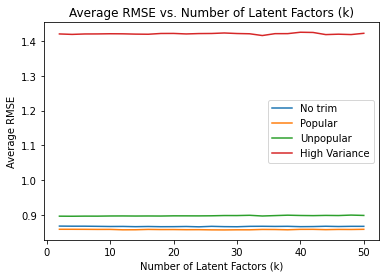

Minimum Average RMSE (No trim): 0.9103307334131756
Minimum Average RMSE (Popular): 0.8560971024807241
Minimum Average RMSE (Unpopular): 0.8955088499092279
Minimum Average RMSE (High Variance): 1.4162803410992293


In [73]:
import matplotlib.pyplot as plt

# Plot results
plt.plot(latent_factors_range, no_trim_rmse_mf_cf[0], label='No trim')
plt.plot(latent_factors_range, popular_rmse_mf_cf[0], label='Popular')
plt.plot(latent_factors_range, unpopular_rmse_mf_cf[0], label='Unpopular')
plt.plot(latent_factors_range, high_variance_rmse_mf_cf[0], label='High Variance')
plt.title('Average RMSE vs. Number of Latent Factors (k)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.legend()
plt.show()

# Report minimum average RMSE
min_avg_no_trim_rmse_mf_cf = min(no_trim_rmse_nmf_cf[0])
min_avg_popular_rmse_mf_cf = min(popular_rmse_mf_cf[0])
min_avg_unpopular_rmse_mf_cf = min(unpopular_rmse_mf_cf[0])
min_avg_high_variance_rmse_mf_cf = min(high_variance_rmse_mf_cf[0])

print("Minimum Average RMSE (No trim):", min_avg_no_trim_rmse_mf_cf)
print("Minimum Average RMSE (Popular):", min_avg_popular_rmse_mf_cf)
print("Minimum Average RMSE (Unpopular):", min_avg_unpopular_rmse_mf_cf)
print("Minimum Average RMSE (High Variance):", min_avg_high_variance_rmse_mf_cf)


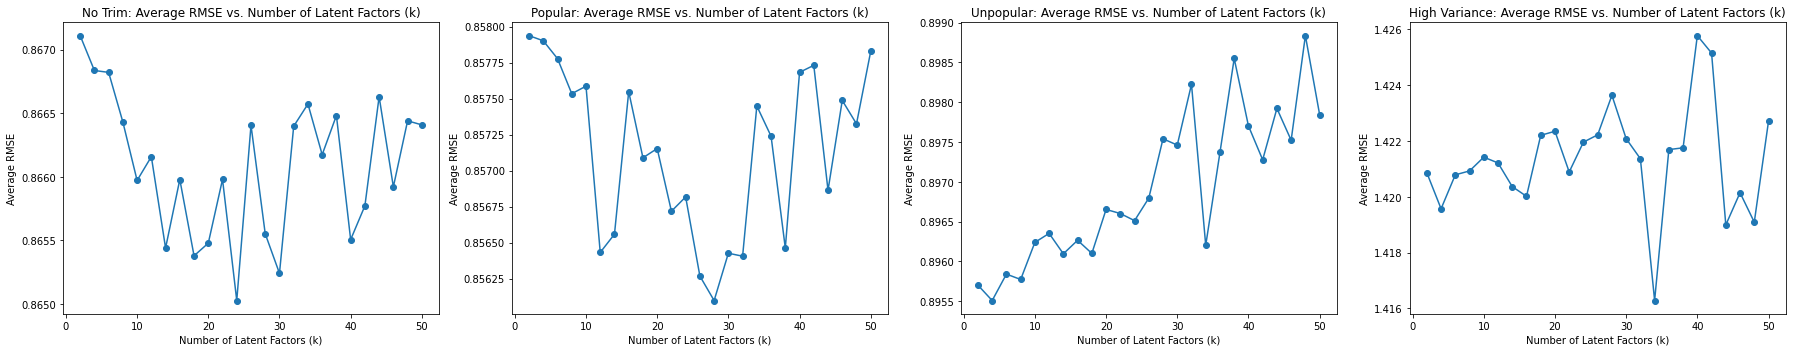

In [74]:
# Plot results
plt.figure(figsize=(25, 5))

plt.subplot(1, 4, 1)
plt.plot(latent_factors_range, no_trim_rmse_mf_cf[0], label='No trim', marker='o')
plt.title('No Trim: Average RMSE vs. Number of Latent Factors (k)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')

plt.subplot(1, 4, 2)
plt.plot(latent_factors_range, popular_rmse_mf_cf[0], label='Popular', marker='o')
plt.title('Popular: Average RMSE vs. Number of Latent Factors (k)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')

plt.subplot(1, 4, 3)
plt.plot(latent_factors_range, unpopular_rmse_mf_cf[0], label='Unpopular', marker='o')
plt.title('Unpopular: Average RMSE vs. Number of Latent Factors (k)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')

plt.subplot(1, 4, 4)
plt.plot(latent_factors_range, high_variance_rmse_mf_cf[0], label='High Variance', marker='o')
plt.title('High Variance: Average RMSE vs. Number of Latent Factors (k)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')

plt.tight_layout()
plt.show()

In [75]:
# No trim
min_rmse_index_mf_cf_no_trim = np.argmin(no_trim_rmse_mf_cf[0])
k_optimal_rmse_mf_cf_no_trim = latent_factors_range[min_rmse_index_mf_cf_no_trim]
print("Optimal number of latent factors for No Trim:", k_optimal_rmse_mf_cf_no_trim)

# Popular
min_rmse_index_mf_cf_popular = np.argmin(popular_rmse_mf_cf[0])
k_optimal_rmse_mf_cf_popular = latent_factors_range[min_rmse_index_mf_cf_popular]
print("Optimal number of latent factors for Popular:", k_optimal_rmse_mf_cf_popular)

# Unpopular
min_rmse_index_mf_cf_unpopular = np.argmin(unpopular_rmse_mf_cf[0])
k_optimal_rmse_mf_cf_unpopular = latent_factors_range[min_rmse_index_mf_cf_unpopular]
print("Optimal number of latent factors for Unpopular:", k_optimal_rmse_mf_cf_unpopular)

# Index of minimum average score 
min_rmse_index_mf_cf_high_var = np.argmin(high_variance_rmse_mf_cf[0])
k_optimal_rmse_mf_cf_high_var = latent_factors_range[min_rmse_index_mf_cf_high_var]
print("Optimal number of latent factors for High Variance:", k_optimal_rmse_mf_cf_high_var)

Optimal number of latent factors for No Trim: 24
Optimal number of latent factors for Popular: 28
Optimal number of latent factors for Unpopular: 4
Optimal number of latent factors for High Variance: 34


## D
Plot the ROC curves for the MF-based collaborative filter and also report the area under the curve (AUC) value as done in Question 6.

In [76]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc

def compute_avg_roc_mf_cf(dataset, latent_factors_range, thresholds): 
    reader = Reader(line_format='user item rating', sep=',', rating_scale=(1, 5), skip_lines=1)
    dataset = Dataset.load_from_df(dataset, reader=reader)
    
    avg_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []

    kf = KFold(n_splits=10, random_state=42)

    for k in latent_factors_range:
        tpr_list = []
        for train, test in kf.split(dataset):
            # Train NMF algorithm on the trainset
            nmf = SVD(n_factors=k)
            nmf.fit(train)

            # Make predictions on the testset
            predictions = nmf.test(test)

            # Extract true ratings and predicted ratings
            true_ratings = np.array([pred.r_ui for pred in predictions])
            predicted_ratings = np.array([pred.est for pred in predictions])

            # per threshold 
            for threshold in thresholds: 
                true_labels = [1 if rating >= threshold else 0 for rating in true_ratings]

                # Compute ROC curve and AUC
                fpr, tpr, roc_auc = compute_roc_auc(true_labels, predicted_ratings)

                # Interpolate ROC curve to average FPR points
                interp_tpr = np.interp(avg_fpr, fpr, tpr)
                interp_tpr[0] = 0.0
                tpr_list.append(interp_tpr)

        # Compute average TPR across all folds
        mean_tpr = np.mean(tpr_list, axis=0)
        mean_tpr[-1] = 1.0
        tprs.append(mean_tpr)

        # Compute AUC for this k
        roc_auc = auc(avg_fpr, mean_tpr)
        aucs.append(roc_auc)

    return avg_fpr, tprs, aucs

In [77]:
def plot_roc_auc_mf_cf(avg_fpr, tprs, aucs, thresholds, latent_factors_range, optimal_k): 
    plt.figure(figsize=(10, 6))
    
    for i, threshold in enumerate(thresholds):
        plt.plot(avg_fpr, tprs[i], lw=1, label=f'Threshold={threshold} (AUC = {aucs[i]:.2f})')
            
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for MF-based Collaborative Filter for k={optimal_k}')
    plt.legend(loc="lower right")
    plt.show()

In [78]:
# Define threshold values
thresholds = [2.5, 3, 3.5, 4]

No Trim

In [79]:
avg_fpr_no_trim_mf_cf, tprs_no_trim_mf_cf, aucs_no_trim_mf_cf = compute_avg_roc_mf_cf(subset_types['no_trim'], latent_factors_range, thresholds)

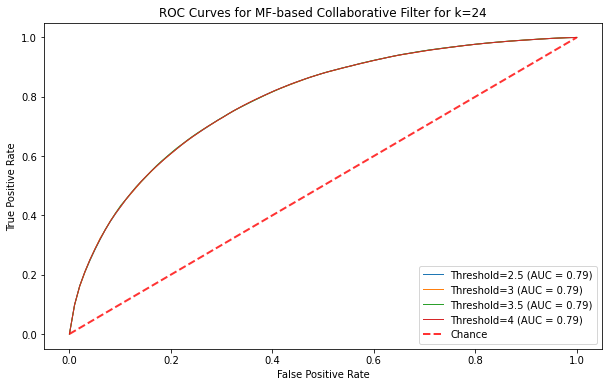

In [80]:
plot_roc_auc_mf_cf(avg_fpr_no_trim_mf_cf, tprs_no_trim_mf_cf, aucs_no_trim_mf_cf, thresholds, latent_factors_range, k_optimal_rmse_mf_cf_no_trim)

Popular

In [81]:
avg_fpr_popular_mf_cf, tprs_popular_mf_cf, aucs_popular_mf_cf = compute_avg_roc_mf_cf(subset_types['popular'], latent_factors_range, thresholds)

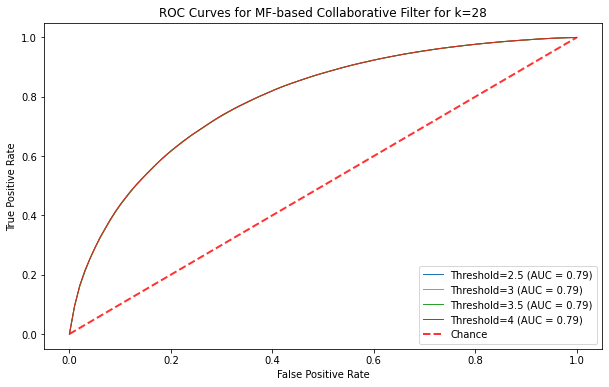

In [82]:
plot_roc_auc_mf_cf(avg_fpr_popular_mf_cf, tprs_popular_mf_cf, aucs_popular_mf_cf, thresholds, latent_factors_range, k_optimal_rmse_mf_cf_popular)

Unpopular

In [83]:
avg_fpr_unpopular_mf_cf, tprs_unpopular_mf_cf, aucs_unpopular_mf_cf = compute_avg_roc_mf_cf(subset_types['unpopular'], latent_factors_range, thresholds)

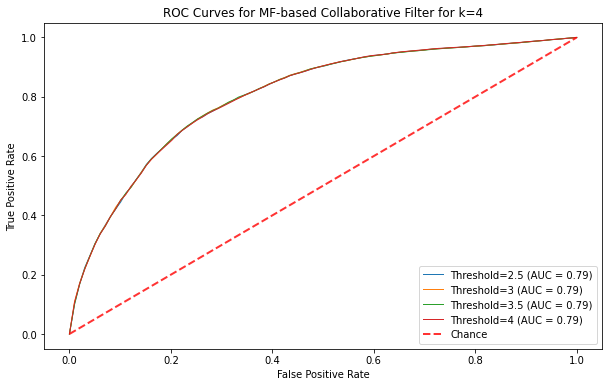

In [84]:
plot_roc_auc_mf_cf(avg_fpr_unpopular_mf_cf, tprs_unpopular_mf_cf, aucs_popular_mf_cf, thresholds, latent_factors_range, k_optimal_rmse_mf_cf_unpopular)

High Variance

In [85]:
avg_fpr_high_var_mf_cf, tprs_high_var_mf_cf, aucs_high_var_mf_cf = compute_avg_roc_mf_cf(subset_types['high_variance'], latent_factors_range, thresholds)

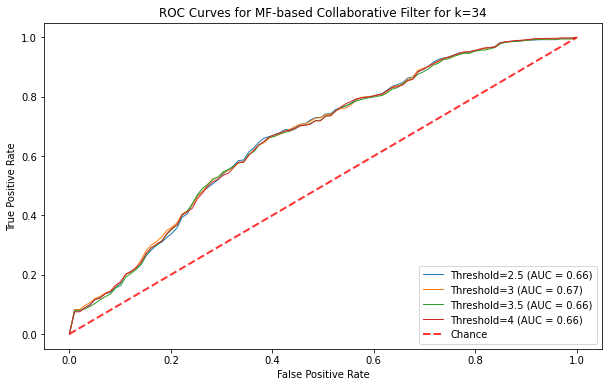

In [86]:
plot_roc_auc_mf_cf(avg_fpr_high_var_mf_cf, tprs_high_var_mf_cf, aucs_high_var_mf_cf, thresholds, latent_factors_range, k_optimal_rmse_mf_cf_high_var)

# Question 11

## A
Design a naive collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.

In [87]:
def compute_avg_rmse_naive_cf(dataset, latent_factors_range): 
    reader = Reader(line_format='user item rating', sep=',', rating_scale=(1, 5), skip_lines=1)
    dataset = Dataset.load_from_df(dataset, reader=reader)

    user_ratings = {}
    avg_user_ratings = {}

    for element in dataset.raw_ratings: 
        uid, iid, rating = element[:3]
        if uid not in user_ratings: 
            user_ratings[uid] = []
        user_ratings[uid].append(rating)
    
    for key, value in user_ratings.items(): 
        avg_user_ratings[key] = np.mean(value)

    # Initialize list to store RMSE scores
    avg_rmse_scores = []
    num_folds = 10

    # Split dataset into folds
    kf = KFold(n_splits=num_folds, random_state=42)

    for k in latent_factors_range:
        rmse_scores = []
        for train, test in kf.split(dataset):
            # Calculate RMSE for the fold
            pred = np.array([avg_user_ratings[uid] for (uid, iid, rating) in test])
            true = np.array([rating for (uid, iid, rating) in test])
            error = pred - true
            
            mse = np.mean(error ** 2)
            rmse_score = np.sqrt(mse)
            rmse_scores.append(rmse_score)
        
        avg_rmse = np.mean(rmse_scores)
        avg_rmse_scores.append(avg_rmse)

    return avg_rmse_scores

In [88]:
avg_rmse_scores_naive_cf = compute_avg_rmse_naive_cf(ratings_df[['userId', 'movieId', 'rating']], latent_factors_range)
print(np.mean(avg_rmse_scores_naive_cf))

0.9347022719742973


In [89]:
print('Average RMSE for Naive Collaborative Filtering: ', np.mean(avg_rmse_scores_naive_cf))

Average RMSE for Naive Collaborative Filtering:  0.9347022719742973


## B
Performance on dataset subsets: For each of Popular, Unpopular and High-Variance test subsets 

Design a naive collaborative filter for each trimmed set and evaluate its performance using 10-fold cross validation.

Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.

In [90]:
no_trim_rmse_naive_cf = compute_avg_rmse_naive_cf(subset_types['no_trim'], latent_factors_range)

In [91]:
popular_rmse_naive_cf = compute_avg_rmse_naive_cf(subset_types['popular'], latent_factors_range)

In [92]:
unpopular_rmse_naive_cf = compute_avg_rmse_naive_cf(subset_types['unpopular'], latent_factors_range)

In [93]:
high_variance_rmse_naive_cf = compute_avg_rmse_naive_cf(subset_types['high_variance'], latent_factors_range)

In [94]:
# Report minimum average RMSE
min_avg_no_trim_rmse_naive_cf = min(no_trim_rmse_naive_cf)
min_avg_popular_rmse_naive_cf = min(popular_rmse_naive_cf)
min_avg_unpopular_rmse_naive_cf = min(unpopular_rmse_naive_cf)
min_avg_high_variance_rmse_naive_cf = min(high_variance_rmse_naive_cf)

print("Minimum Average RMSE (No Trim):", min_avg_no_trim_rmse_naive_cf)
print("Minimum Average RMSE (Popular):", min_avg_no_trim_rmse_naive_cf)
print("Minimum Average RMSE (Unpopular):", min_avg_unpopular_rmse_naive_cf)
print("Minimum Average RMSE (High Variance):", min_avg_high_variance_rmse_naive_cf)

Minimum Average RMSE (No Trim): 0.9347022719742973
Minimum Average RMSE (Popular): 0.9347022719742973
Minimum Average RMSE (Unpopular): 0.84085363708971
Minimum Average RMSE (High Variance): 0.917422049412157


# Question 12 
Comparing the most performant models across architecture: Plot the best ROC curves (threshold = 3) for the k-NN, NMF, and MF with bias based  ollaborative filters in the same figure. Use the figure to compare the performance of the filters in predicting the ratings of the movies.

In [95]:
reader = Reader(rating_scale = (0.5,5))
data = Dataset.load_from_df(df_ratings[['userId','movieId','rating']], reader)

In [96]:
def compute_avg_rmse(dataset, model):
    kf = KFold(n_splits=10)
    all_true_labels = []
    all_predicted_labels = []

    for trainset, testset in kf.split(dataset):
        model.fit(trainset)
        predictions = model.test(testset)

        # Extract true and predicted ratings
        true_labels = [pred.r_ui for pred in predictions]
        predicted_labels = [pred.est for pred in predictions]

        # Append true and predicted labels to the lists
        all_true_labels.extend(true_labels)
        all_predicted_labels.extend(predicted_labels)

    return all_true_labels, all_predicted_labels

In [98]:
# Models
knn_model = KNNBasic(k=20, sim_options={'name': 'pearson', 'user_based': True})
nmf_model = NMF(n_factors=20)
mf_with_bias_model = SVD(n_factors=26)

# Compute true and predicted labels for each model
true_labels_knn, predicted_labels_knn = compute_avg_rmse(data, knn_model)
true_labels_nmf, predicted_labels_nmf = compute_avg_rmse(data, nmf_model)
true_labels_mf_with_bias, predicted_labels_mf_with_bias = compute_avg_rmse(data, mf_with_bias_model)

# Define threshold for binary classification
threshold = 3

# Binarize the true labels for each model based on the threshold
binary_true_labels_knn = [1 if true_label >= threshold else 0 for true_label in true_labels_knn]
binary_true_labels_nmf = [1 if true_label >= threshold else 0 for true_label in true_labels_nmf]
binary_true_labels_mf_with_bias = [1 if true_label >= threshold else 0 for true_label in true_labels_mf_with_bias]

# Binarize the predicted ratings for each model based on the threshold
binary_predicted_labels_knn = [1 if pred >= threshold else 0 for pred in predicted_labels_knn]
binary_predicted_labels_nmf = [1 if pred >= threshold else 0 for pred in predicted_labels_nmf]
binary_predicted_labels_mf_with_bias = [1 if pred >= threshold else 0 for pred in predicted_labels_mf_with_bias]

# Compute ROC curves and AUC for each model using binary labels
fpr_knn, tpr_knn, _ = roc_curve(binary_true_labels_knn, binary_predicted_labels_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_nmf, tpr_nmf, _ = roc_curve(binary_true_labels_nmf, binary_predicted_labels_nmf)
roc_auc_nmf = auc(fpr_nmf, tpr_nmf)

fpr_mf_with_bias, tpr_mf_with_bias, _ = roc_curve(binary_true_labels_mf_with_bias, binary_predicted_labels_mf_with_bias)
roc_auc_mf_with_bias = auc(fpr_mf_with_bias, tpr_mf_with_bias)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


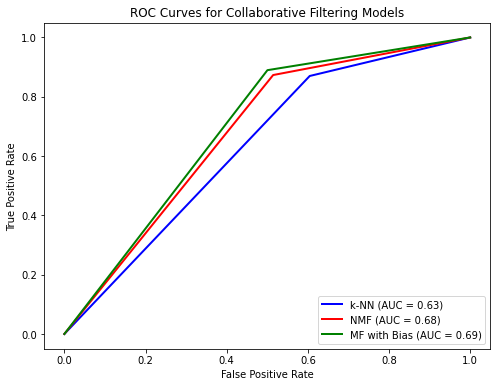

In [99]:
# Plot ROC curves for all models
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label='k-NN (AUC = %0.2f)' % roc_auc_knn)
plt.plot(fpr_nmf, tpr_nmf, color='red', lw=2, label='NMF (AUC = %0.2f)' % roc_auc_nmf)
plt.plot(fpr_mf_with_bias, tpr_mf_with_bias, color='green', lw=2, label='MF with Bias (AUC = %0.2f)' % roc_auc_mf_with_bias)

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Collaborative Filtering Models')
plt.legend(loc='lower right')

# Display the plot
plt.show()

The AUC value is the highest for the MF with bias collaborative filter model therefore making it a better predictor than k-NN and NMF for the prediction of movie ratings.

# Question 13 
Use the provided helper code for loading and preprocessing Web10k data. Print out the number of unique queries in total and show distribution of relevance labels.

In [2]:
! pip install lightgbm

In [3]:
# Load the dataset for one fold
def load_one_fole(data_path):
    X_train, y_train, qid_train = load_svmlight_file(str(data_path + 'train.txt'), query_id=True)
    X_test, y_test, qid_test = load_svmlight_file(str(data_path + 'test.txt'), query_id=True)
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    _, group_train = np.unique(qid_train, return_counts=True)
    _, group_test = np.unique(qid_test, return_counts=True)
    return X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test

def ndcg_single_query(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

# calculate NDCG score given a trained model 
def compute_ndcg_all(model, X_test, y_test, qids_test, k=10):
    unique_qids = np.unique(qids_test)
    ndcg_ = list()
    for i, qid in enumerate(unique_qids):
        y = y_test[qids_test == qid]

        if np.sum(y) == 0:
            continue

        p = model.predict(X_test[qids_test == qid])

        idcg = ndcg_single_query(y, y, k=k)
        ndcg_.append(ndcg_single_query(p, y, k=k) / idcg)
    return np.mean(ndcg_)

# get importance of features
def get_feature_importance(model, importance_type='gain'):
    return model.booster_.feature_importance(importance_type=importance_type)

Fold1: val:[0 1 2 3 4] count:[502741 310465 127541  17108   7078]
Fold2: val:[0 1 2 3 4] count:[499479 308384 126992  16867   6949]
Fold3: val:[0 1 2 3 4] count:[497813 308264 127576  17264   7287]
Fold4: val:[0 1 2 3 4] count:[498175 310318 128538  16956   7112]
Fold5: val:[0 1 2 3 4] count:[498844 307689 127157  17073   7098]


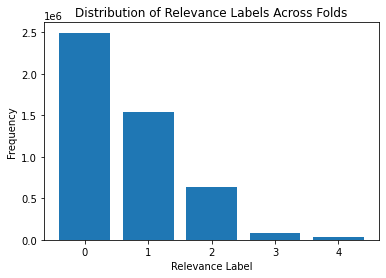

In [4]:
datapath = './MSLR-WEB10K'

total_counts = np.zeros(5, dtype=int)

# Loop through each fold
for fold_num in range(1, 6):
    # Load data for the current fold
    fold_path = os.path.join(datapath, f'Fold{fold_num}/')
    _, y_train, _, _, _, y_test, _, _ = load_one_fole(fold_path)

    # Calculate and print distribution of relevance labels for the current fold
    unique_labels, label_counts = np.unique(np.concatenate([y_train, y_test]), return_counts=True)
    print(f'Fold{fold_num}: val:{unique_labels} count:{label_counts}')

    # Update total counts
    total_counts += label_counts

# Combine counts across all folds into a single plot
relevance_labels = [0, 1, 2, 3, 4]

# Plot the total frequency of relevance labels
plt.bar(relevance_labels, total_counts)
plt.xlabel('Relevance Label')
plt.ylabel('Frequency')
plt.title('Distribution of Relevance Labels Across Folds')
plt.show()

In [5]:
# Print the combined counts
print("\nCombined counts across all folds:")
print("relevance label:  0                 1                  2                 3               4")
print(f"frequency:      {total_counts[0]}         {total_counts[1]}              {total_counts[2]}            {total_counts[3]}           {total_counts[4]}")


Combined counts across all folds:
relevance label:  0                 1                  2                 3               4
frequency:      2497052         1545120              637804            85268           35524


# Question 14
For each of the five provided folds, train a LightGBM model using the ’lambdarank’ objective. After
training, evaluate and report the model’s performance on the test set using nDCG@3, nDCG@5 and
nDCG@10

In [6]:
datapath = './MSLR-WEB10K'

results = []

for fold_num in range(1, 6):
    # Load data for the current fold
    fold_path = os.path.join(datapath, f'Fold{fold_num}/')
    X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test = load_one_fole(fold_path)

    # LightGBM model with 'lambdarank' objective
    params = {'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_eval_at': [3, 5, 10], 'verbose': 0}
    fold_train_data = lgb.Dataset(X_train, label=y_train, group=group_train, free_raw_data=False)
    fold_test_data = lgb.Dataset(X_test, label=y_test, group=group_test, free_raw_data=False)

    lgb_model = lgb.train(params, fold_train_data, valid_sets=[fold_test_data])

    # Evalauting the model on the test set
    ndcg3 = compute_ndcg_all(lgb_model, X_test, y_test, qid_test, k=3)
    ndcg5 = compute_ndcg_all(lgb_model, X_test, y_test, qid_test, k=5)
    ndcg10 = compute_ndcg_all(lgb_model, X_test, y_test, qid_test, k=10)

    results.append({'fold': fold_num, 'ndcg@3': ndcg3, 'ndcg@5': ndcg5, 'ndcg@10': ndcg10})

print("\nEvaluation Results:")
for r in results:
    print(f"Fold {r['fold']}: nDCG@3 = {r['ndcg@3']:.4f}, nDCG@5 = {r['ndcg@5']:.4f}, nDCG@10 = {r['ndcg@10']:.4f}")





Evaluation Results:
Fold 1: nDCG@3 = 0.4565, nDCG@5 = 0.4633, nDCG@10 = 0.4829
Fold 2: nDCG@3 = 0.4538, nDCG@5 = 0.4572, nDCG@10 = 0.4767
Fold 3: nDCG@3 = 0.4491, nDCG@5 = 0.4583, nDCG@10 = 0.4759
Fold 4: nDCG@3 = 0.4612, nDCG@5 = 0.4663, nDCG@10 = 0.4877
Fold 5: nDCG@3 = 0.4697, nDCG@5 = 0.4715, nDCG@10 = 0.4905


# Question 15
For each of the five provided folds, list top 5 most important features of the model based on
the importance score. Please use model.booster .feature importance(importance type=’gain’) as
demonstrated here for retrieving importance score per feature. You can also find helper code in the
provided notebook.

In [7]:
datapath = './MSLR-WEB10K'

for fold_num in range(1, 6):
    # Load data for the current fold
    fold_path = os.path.join(datapath, f'Fold{fold_num}/')
    X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test = load_one_fole(fold_path)

    # LightGBM model with 'lambdarank' objective
    params = {'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_eval_at': [3, 5, 10], 'verbose': 0}
    fold_train_data = lgb.Dataset(X_train, label=y_train, group=group_train, free_raw_data=False)
    fold_test_data = lgb.Dataset(X_test, label=y_test, group=group_test, free_raw_data=False)

    lgb_model = lgb.train(params, fold_train_data, valid_sets=[fold_test_data])

    # Get feature importance
    feature_importance = lgb_model.feature_importance(importance_type="gain")

    # Find and print the top 5 most important features
    top_features_indices = np.argsort(feature_importance)[::-1][:5]
    top_features = [f"Feature {idx + 1}" for idx in top_features_indices]
    
    print(f"\nTop 5 features for Fold {fold_num} based on importance score:")
    for feature in top_features:
        print(feature)


Top 5 features for Fold 1 based on importance score:
Feature 134
Feature 8
Feature 108
Feature 55
Feature 130

Top 5 features for Fold 2 based on importance score:
Feature 134
Feature 8
Feature 55
Feature 108
Feature 130

Top 5 features for Fold 3 based on importance score:
Feature 134
Feature 55
Feature 108
Feature 130
Feature 8

Top 5 features for Fold 4 based on importance score:
Feature 134
Feature 8
Feature 55
Feature 130
Feature 129

Top 5 features for Fold 5 based on importance score:
Feature 134
Feature 8
Feature 55
Feature 108
Feature 130


# Question 16.1
For each of the five provided folds:
- Remove the top 20 most important features according to the computed importance score in
the question 15. Then train a new LightGBM model on the resulted 116 dimensional query-
url data. Evaluate the performance of this new model on the test set using nDCG. Does
the outcome align with your expectations? If not, please share your hypothesis regarding the
potential reasons for this discrepancy.

In [8]:
datapath = './MSLR-WEB10K'

for fold_num in range(1, 6):
    # Load data for the current fold
    fold_path = os.path.join(datapath, f'Fold{fold_num}/')
    X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test = load_one_fole(fold_path)

    # LightGBM model with 'lambdarank' objective
    params = {'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_eval_at': [3, 5, 10], 'verbose': 0}
    fold_train_data = lgb.Dataset(X_train, label=y_train, group=group_train, free_raw_data=False)
    fold_test_data = lgb.Dataset(X_test, label=y_test, group=group_test, free_raw_data=False)

    lgb_model = lgb.train(params, fold_train_data, valid_sets=[fold_test_data])

    # Get feature importance
    feature_importance = lgb_model.feature_importance(importance_type="gain")

    # Get the indices of the top 20 features
    top20_indices = np.argsort(feature_importance)[::-1][:20]

    # Remove top 20 features
    X_train_top20 = np.delete(X_train.toarray(), top20_indices, axis=1)
    X_test_top20 = np.delete(X_test.toarray(), top20_indices, axis=1)

    model_top20 = lgb.train(params, lgb.Dataset(X_train_top20, label=y_train, group=group_train, free_raw_data=False))

    # Evaluate the performance on the test set using nDCG
    ndcg3_top20 = compute_ndcg_all(model_top20, X_test_top20, y_test, qid_test, k=3)
    ndcg5_top20 = compute_ndcg_all(model_top20, X_test_top20, y_test, qid_test, k=5)
    ndcg10_top20 = compute_ndcg_all(model_top20, X_test_top20, y_test, qid_test, k=10)
    print(f"Fold {fold_num} - After removing top 20 features: nDCG@3 = {ndcg3_top20:.4f}, nDCG@5 = {ndcg5_top20:.4f}, nDCG@10 = {ndcg10_top20:.4f}")

Fold 1 - After removing top 20 features: nDCG@3 = 0.3792, nDCG@5 = 0.3849, nDCG@10 = 0.4081
Fold 2 - After removing top 20 features: nDCG@3 = 0.3739, nDCG@5 = 0.3821, nDCG@10 = 0.4046
Fold 3 - After removing top 20 features: nDCG@3 = 0.3821, nDCG@5 = 0.3898, nDCG@10 = 0.4114
Fold 4 - After removing top 20 features: nDCG@3 = 0.3821, nDCG@5 = 0.3929, nDCG@10 = 0.4123
Fold 5 - After removing top 20 features: nDCG@3 = 0.3852, nDCG@5 = 0.3928, nDCG@10 = 0.4169


Yes, the outcome does align with my expectations. After removing the top 20 features, I see a decrease in nDCG values for k=3,5,10. This indicates that the top 20 features could include important information for the model to accurately predict the relevance of queries to labels. This could also mean that the original LightGBM model was sensitive to the top 20 features and removing the top 20 features could have cause the model to overfit to the training data.

# Question 16.2
For each of the five provided folds:
- Remove the 60 least important features according to the computed importance score in the
question 15. Then train a new LightGBM model on the resulted 76 dimensional query-url data.
Evaluate the performance of this new model on the test set using nDCG. Does the outcome
align with your expectations? If not, please share your hypothesis regarding the potential
reasons for this discrepancy.

In [9]:
datapath = './MSLR-WEB10K'

for fold_num in range(1, 6):
    # Load data for the current fold
    fold_path = os.path.join(datapath, f'Fold{fold_num}/')
    X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test = load_one_fole(fold_path)

    # LightGBM model with 'lambdarank' objective
    params = {'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_eval_at': [3, 5, 10], 'verbose': 0}
    fold_train_data = lgb.Dataset(X_train, label=y_train, group=group_train, free_raw_data=False)
    fold_test_data = lgb.Dataset(X_test, label=y_test, group=group_test, free_raw_data=False)

    lgb_model = lgb.train(params, fold_train_data, valid_sets=[fold_test_data])

    # Get feature importance
    feature_importance = lgb_model.feature_importance(importance_type="gain")

    # Get the indices of the bottom 60 features
    bottom60_indices = np.argsort(feature_importance)[:60]

    # Remove top 20 features
    X_train_bottom60 = np.delete(X_train.toarray(), bottom60_indices, axis=1)
    X_test_bottom60 = np.delete(X_test.toarray(), bottom60_indices, axis=1)

    model_bottom60 = lgb.train(params, lgb.Dataset(X_train_bottom60, label=y_train, group=group_train, free_raw_data=False))

    # Evaluate the performance on the test set using nDCG
    ndcg3_bottom60 = compute_ndcg_all(model_bottom60, X_test_bottom60, y_test, qid_test, k=3)
    ndcg5_bottom60 = compute_ndcg_all(model_bottom60, X_test_bottom60, y_test, qid_test, k=5)
    ndcg10_bottom60 = compute_ndcg_all(model_bottom60, X_test_bottom60, y_test, qid_test, k=10)
    print(f"Fold {fold_num} - After removing bottom 60 features: nDCG@3 = {ndcg3_bottom60:.4f}, nDCG@5 = {ndcg5_bottom60:.4f}, nDCG@10 = {ndcg10_bottom60:.4f}")

Fold 1 - After removing bottom 60 features: nDCG@3 = 0.4541, nDCG@5 = 0.4627, nDCG@10 = 0.4821
Fold 2 - After removing bottom 60 features: nDCG@3 = 0.4572, nDCG@5 = 0.4602, nDCG@10 = 0.4772
Fold 3 - After removing bottom 60 features: nDCG@3 = 0.4499, nDCG@5 = 0.4585, nDCG@10 = 0.4774
Fold 4 - After removing bottom 60 features: nDCG@3 = 0.4607, nDCG@5 = 0.4672, nDCG@10 = 0.4889
Fold 5 - After removing bottom 60 features: nDCG@3 = 0.4704, nDCG@5 = 0.4736, nDCG@10 = 0.4910


Yes, the outcome does align with my expectations. Removing thte bottom 60 features did not make much of a difference to the nDCG values for k=3,5,10. This indicates that the bottom 60 features could have been redundant data and removing them did not make a difference to the model performance which suggests that the model is robust.